In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()

import xgboost as xgb
from sklearn.metrics import mean_squared_error
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('Data/AEP_hourly.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%Y-%m-%d %H:%M:%S')
df = df.set_index('Datetime')

In [3]:
df.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121273 entries, 2004-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AEP_MW  121273 non-null  float64
dtypes: float64(1)
memory usage: 1.9 MB


<Axes: title={'center': 'PJME Energy Used in MW'}, xlabel='Datetime'>

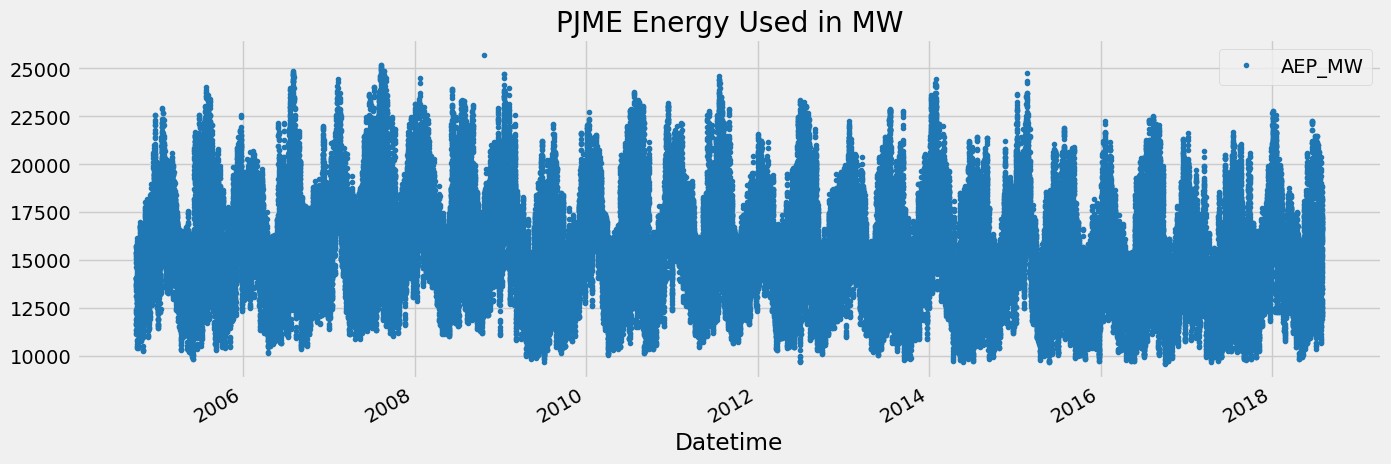

In [5]:
df.plot(style='.', figsize=(15,5),
        color=color_pal[0],
        title='PJME Energy Used in MW')

## Train / Test Split

In [6]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

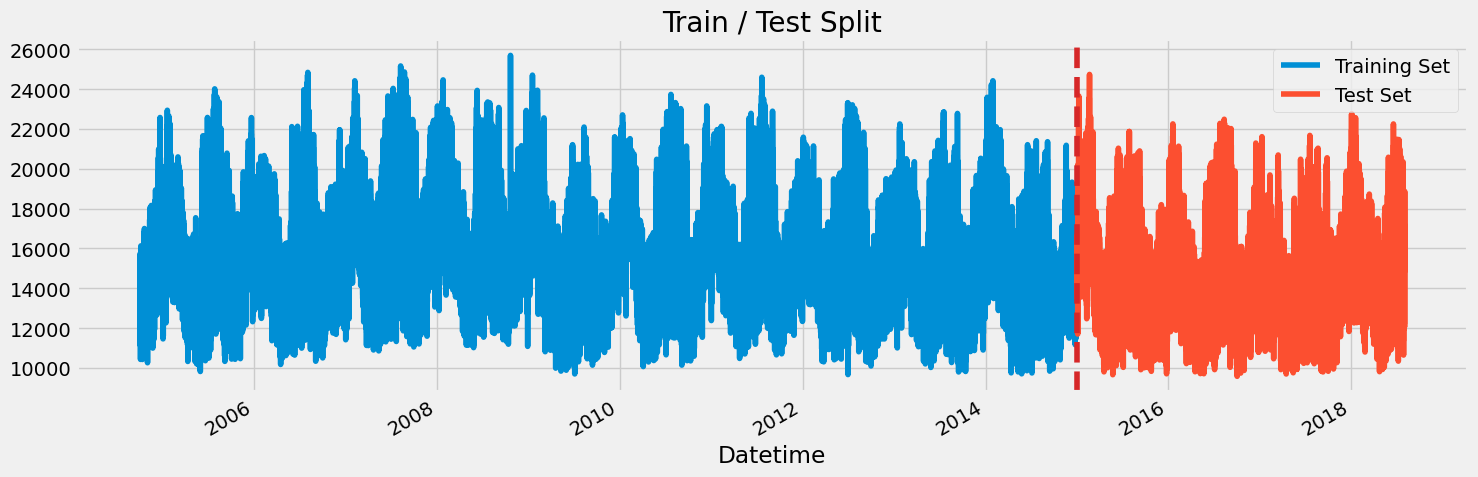

In [7]:
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set', kind='line', title='Train / Test Split')
test.plot(ax=ax, label='Testing Set', kind='line', legend='Testing Set')
ax.axvline('01-01-2015', color=color_pal[3], ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.tight_layout()
plt.show()


In [8]:
A_week = df.loc[(df.index >'01-01-2010') & (df.index < '01-08-2010')]

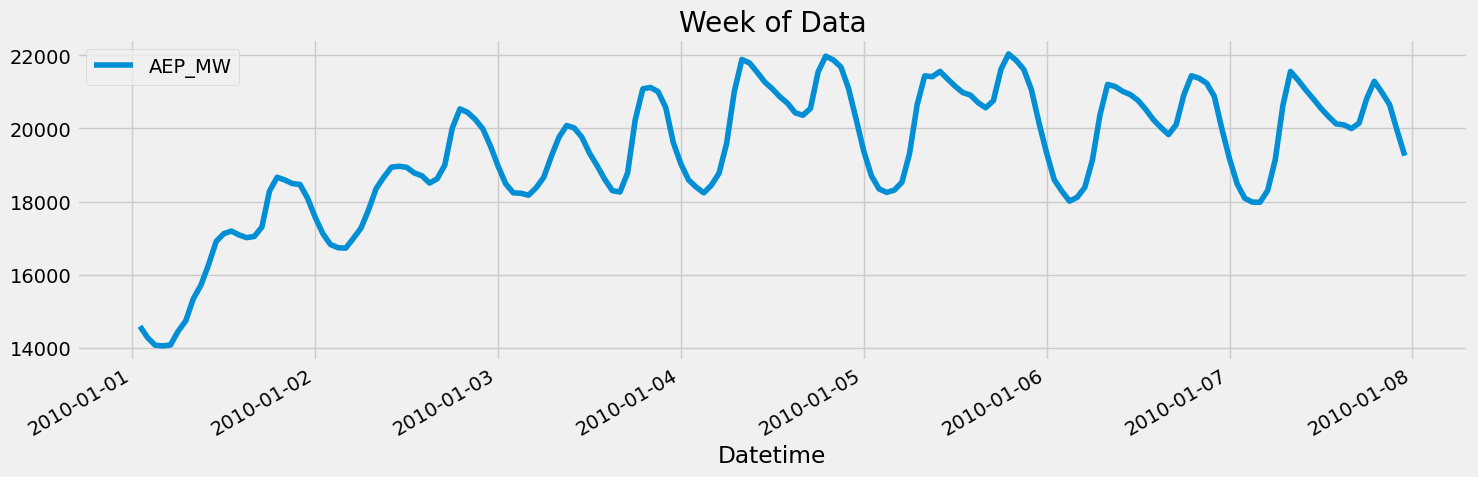

In [9]:
fig, ax = plt.subplots(figsize=(15,5))
A_week.plot(ax=ax, title='Week of Data')
plt.tight_layout()
plt.show()

# Feature Creation

In [10]:
def create_features(df):
    '''
    Create time series features based on time series index.
    '''
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.day_of_year
    return df

df = create_features(df)

# Visualize our Feature / Target Relationship

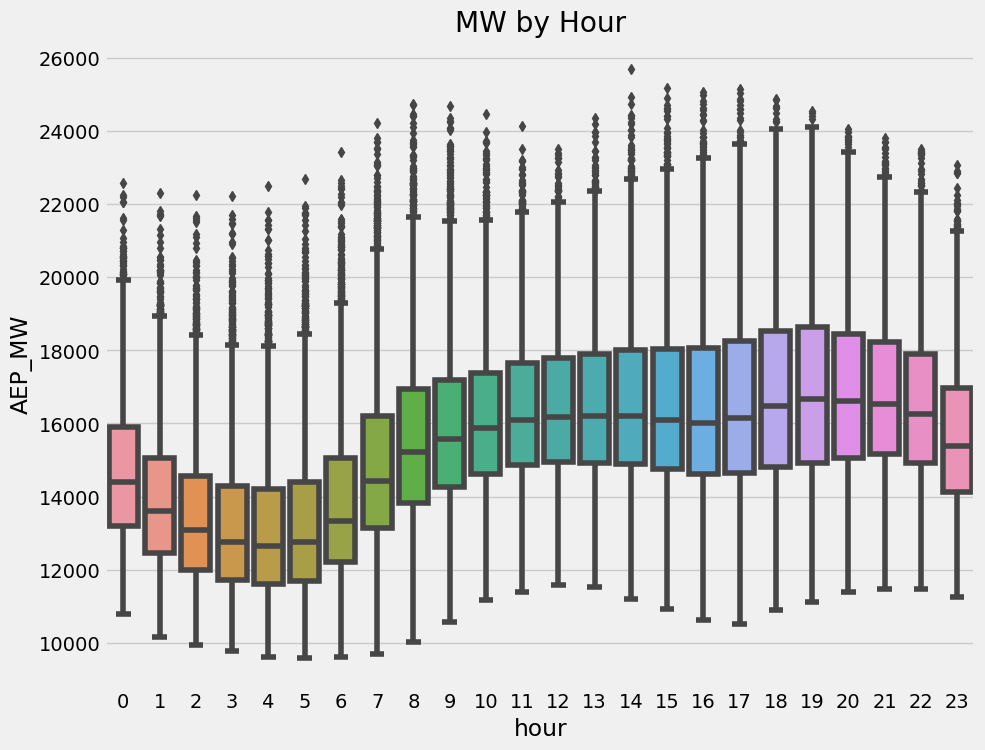

In [11]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='hour', y='AEP_MW')
ax.set_title('MW by Hour')
plt.show()

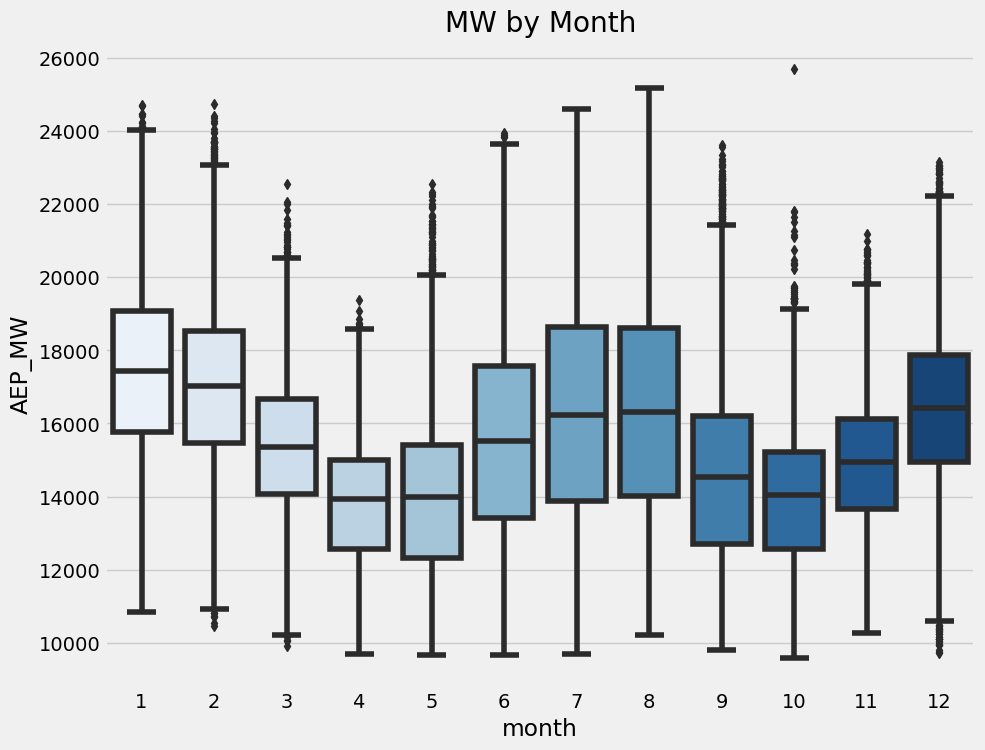

In [12]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='month', y='AEP_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

# Create Our Model

In [13]:
train = create_features(train)
test = create_features(test)

In [14]:
df.columns

Index(['AEP_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear'], dtype='object')

In [15]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'AEP_MW'

In [16]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [17]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds = 50, learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100
        )

[0]	validation_0-rmse:15792.50936	validation_1-rmse:14861.30366
[100]	validation_0-rmse:5946.76890	validation_1-rmse:5177.35119
[200]	validation_0-rmse:2508.95368	validation_1-rmse:2124.36626
[300]	validation_0-rmse:1472.70614	validation_1-rmse:1577.19471
[383]	validation_0-rmse:1224.68852	validation_1-rmse:1579.14003


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

# Feature Importance

In [18]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_, columns=['Importance'])
fi

,Importance
hour,0.431384
dayofweek,0.188986
quarter,0.018132
month,0.177474
year,0.051083
dayofyear,0.132941


<Axes: title={'center': 'Feature Importance'}>

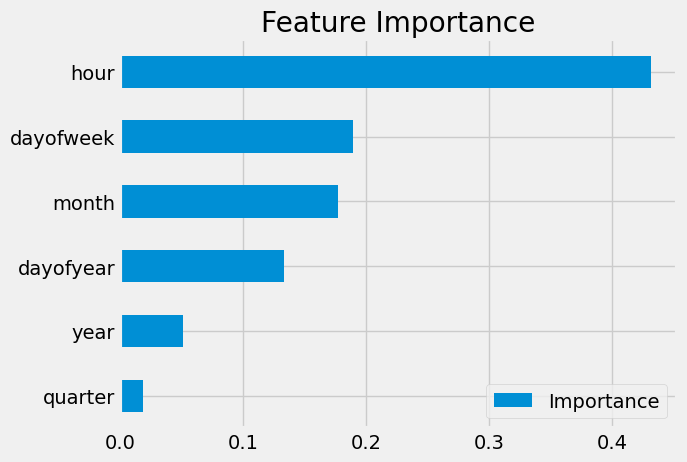

In [19]:
fi.sort_values('Importance').plot(kind='barh', title='Feature Importance')

# Forecast on Test

In [20]:
test['prediction'] = reg.predict(X_test)

In [21]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

In [25]:
df.tail()

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,prediction
Datetime,,,,,,,,
2018-08-02 20:00:00,17673.0,20,3,3,8,2018,214,17750.716797
2018-08-02 21:00:00,17303.0,21,3,3,8,2018,214,17750.716797
2018-08-02 22:00:00,17001.0,22,3,3,8,2018,214,17592.007812
2018-08-02 23:00:00,15964.0,23,3,3,8,2018,214,16194.920898
2018-08-03 00:00:00,14809.0,0,4,3,8,2018,215,13909.329102


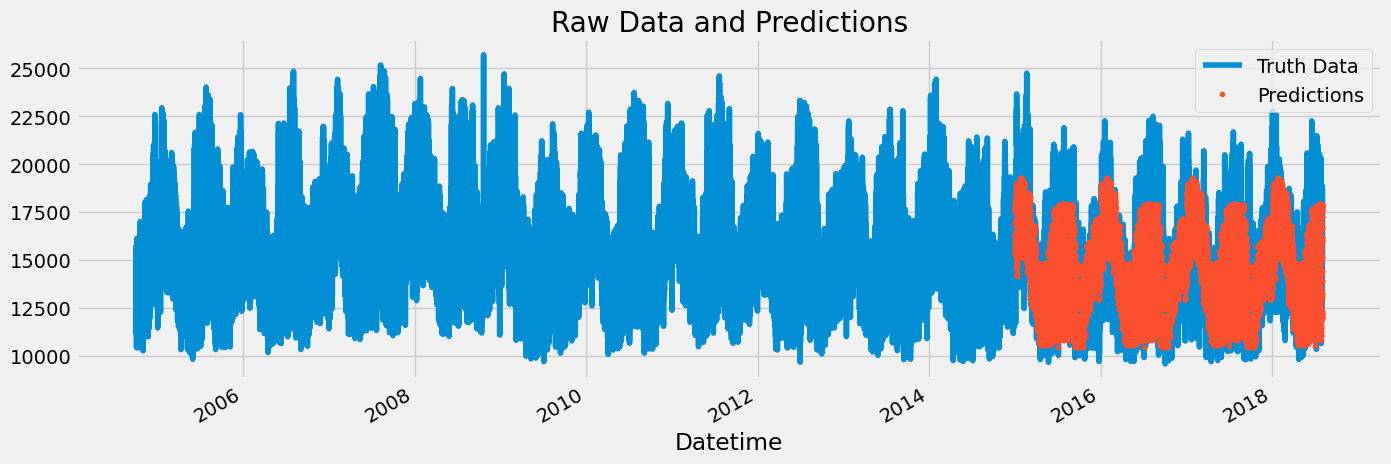

In [26]:
ax = df[['AEP_MW']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Predictions')
plt.show()

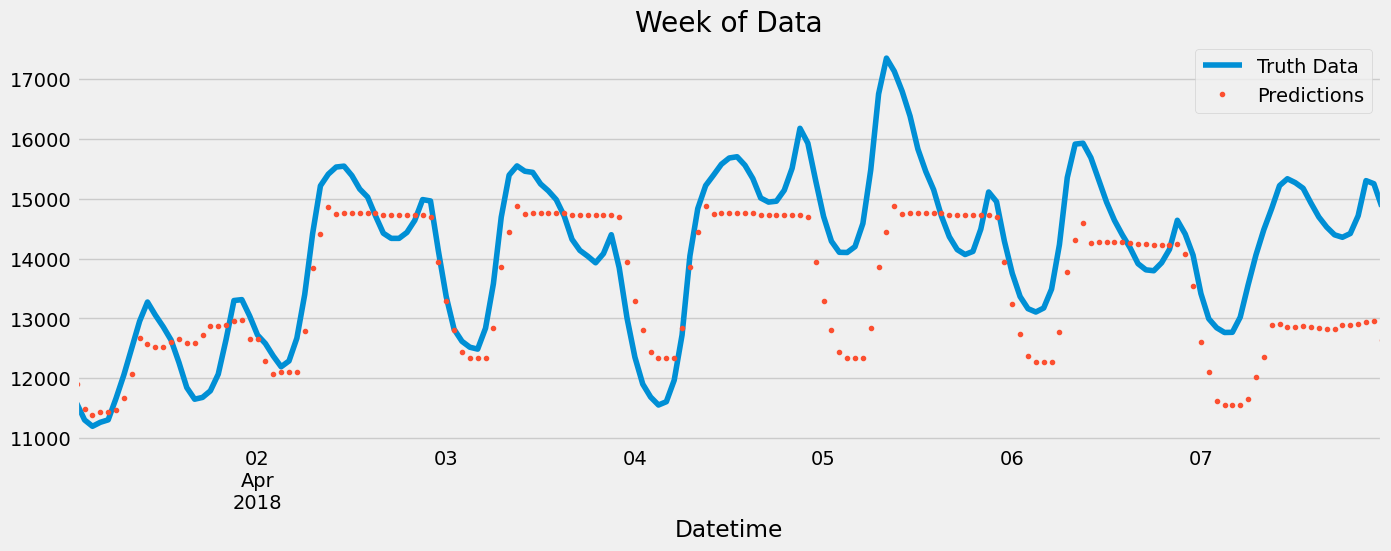

In [28]:
A_week = df.loc[(df.index >'04-01-2018') & (df.index < '04-08-2018')]['AEP_MW'].plot(figsize=(15,5), title='Week of Data')
df.loc[(df.index >'04-01-2018') & (df.index < '04-08-2018')]['prediction'].plot(style='.')
plt.legend(['Truth Data', 'Predictions'])
plt.show()

In [31]:
score = np.sqrt(mean_squared_error(test['AEP_MW'], test['prediction']))
print(f"RMSE Score on Test Set: {score:0.2f}")

RMSE Score on Test Set: 1563.38


# Calculate Error

In [34]:
test['error'] = np.abs(test[TARGET] - test['prediction'])

In [35]:
test['date'] = test.index.date

In [36]:
test.groupby('date')['error'].mean().sort_values(ascending=False).head()

date
2015-02-20    5461.675130
2015-02-19    5360.712606
2018-01-06    5083.077718
2018-01-07    4693.319539
2015-02-16    4321.795817
Name: error, dtype: float64

In [37]:
test.groupby('date')['error'].mean().sort_values(ascending=True).head()

date
2015-09-26    207.230632
2017-05-21    210.977254
2017-11-16    213.768026
2017-10-12    220.800659
2016-06-05    222.770793
Name: error, dtype: float64